In [1]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#1 

a) Detect the “skin-pixels” in a color image. Create a new binary image, the same size as the input
color image, in which the skin pixels are white (255) and all non-skin pixels are black (0).
Implement all the below described methods. (test images)

In [2]:
def detect_skin(image):
    hsv_image = cv.cvtColor(image,cv.COLOR_BGR2HSV)

    low = np.array([0,20,70],dtype=np.uint8)
    upper = np.array([20,255,255],dtype=np.uint8)

    mask = cv.inRange(hsv_image,low,upper)

    kernel = np.ones((5,5),np.uint8)
    mask = cv.dilate(mask,kernel,iterations=1)
    return mask

In [3]:
def apply_skin_detection(in_folder,out_folder):
        if not os.path.exists(out_folder):
                os.makedirs(out_folder)
        
        images = [f for f in os.listdir(in_folder) if f.lower().endswith('.jpg')]
        for image in images:
                image_path = image
                new_image_path = os.path.join(in_folder,image)
                image = cv.imread(new_image_path)
                if image is None:
                    print(f"ERROR :  can't loade image {new_image_path}.")
                    continue
        
                mask = detect_skin(image)
                out_path = os.path.join(out_folder,f"skin_{image_path}")
                cv.imwrite(out_path,mask)
                print(f"Image processed {new_image_path} into {out_path}")

In [4]:
if __name__ == '__main__':
    input_folder = 'skin'
    output_folder = 'skin_out'

    apply_skin_detection(input_folder, output_folder)

b)
Evaluate the below described methods by using the Pratheepan dataset. For the images in this
dataset the “ground truth” information is provided. Compute and display the confusion matrix
and the accuracy. The confusion matrix has the following form:


In [5]:
def loadImages(image_dir, mask_dir):
    image_paths = sorted(os.listdir(image_dir))
    mask_paths = sorted(os.listdir(mask_dir))

    images = []
    masks = []

    for image_name, mask_name in zip(image_paths, mask_paths):
        image = cv.imread(os.path.join(image_dir, image_name))
        mask = cv.imread(os.path.join(mask_dir, mask_name))

        if image is not None and mask is not None:
            if image.shape[:2] != mask.shape[:2]:
                print(f"Warning: Dimensiunile imaginii {image_name} și măștii {mask_name} nu coincid.")
                mask = cv.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv.INTER_NEAREST)

            if mask.shape[-1] == 3:
                mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)

            images.append(image)
            masks.append(mask)
        else:
            print(f"Warning: Imagine sau mască lipsă pentru {image_name} sau {mask_name}")

    return images, masks

In [6]:
def apply_skin_detection(images):
    predictions = []
    kernel = np.ones((5, 5), np.uint8)

    for image in images:

        mask = detect_skin(image)

        mask_dilated = cv.dilate(mask, kernel, iterations=1)

        mask_resized = cv.resize(mask_dilated, (image.shape[1], image.shape[0]), interpolation=cv.INTER_NEAREST)

        predictions.append(mask_resized)

    return predictions

def evaluate_confusion(predictions, labels):
    for i, (pred, label) in enumerate(zip(predictions, labels)):
        if pred.shape != label.shape:
            raise ValueError(f"Shape mismatch at index {i}: prediction shape={pred.shape}, label shape={label.shape}")

    y_pred = np.concatenate([prediction.flatten() for prediction in predictions])
    y_label = np.concatenate([label.flatten() for label in labels])
    
    if len(y_pred) != len(y_label):
        raise ValueError(f"Inconsistent number of samples: y_pred={len(y_pred)}, y_label={len(y_label)}")

    matrix = confusion_matrix(y_label, y_pred)
    TP = matrix[1, 1]
    TN = matrix[0, 0]
    FP = matrix[0, 1]
    FN = matrix[1, 0]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return matrix, accuracy

In [7]:
def plot_confusion_matrix(matrix):
    """
    Function to plot the confusion matrix using Seaborn heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


In [8]:
if __name__ == "__main__":
    
    face_photo_dir = "Pratheepan_Dataset/FacePhoto/"
    family_photo_dir = "Pratheepan_Dataset/FamilyPhoto/"
    ground_truth_face_dir = "Ground_Truth/GroundT_FacePhoto/"
    ground_truth_family_dir = "Ground_Truth/GroundT_FamilyPhoto/"
    face_images, face_masks = loadImages(face_photo_dir, ground_truth_face_dir)
    family_images, family_masks = loadImages(family_photo_dir, ground_truth_family_dir)

    face_predictions = apply_skin_detection(face_images)
    family_predictions = apply_skin_detection(family_images) 

    face_confusion_matrix, face_accuracy = evaluate_confusion(face_predictions, face_masks)
    print("Face Photos Confusion Matrix:")
    print(face_confusion_matrix)
    print("Face Photos Accuracy:", face_accuracy)

    family_confusion_matrix, family_accuracy = evaluate_confusion(family_predictions, family_masks)
    print("Family Photos Confusion Matrix:")
    print(family_confusion_matrix)
    print("Family Photos Accuracy:", family_accuracy)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Face Photos Confusion Matrix:
[[2184496 2176917]
 [  19591 1532303]]
Face Photos Accuracy: 0.6285482894765991
Family Photos Confusion Matrix:
[[6397996       0       0 ...       0       0 4888589]
 [     17       0       0 ...       0       0       5]
 [     17       0       0 ...       0       0      14]
 ...
 [      0       0       0 ...       0       0       1]
 [      1       0       0 ...       0       0       0]
 [  30899       0       0 ...       0       0 1567689]]
Family Photos Accuracy: 0.9999973429250613


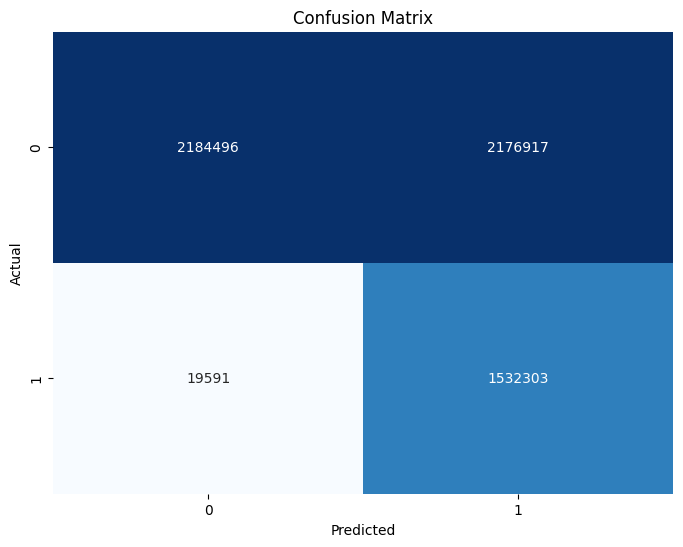

In [9]:
plot_confusion_matrix(face_confusion_matrix)


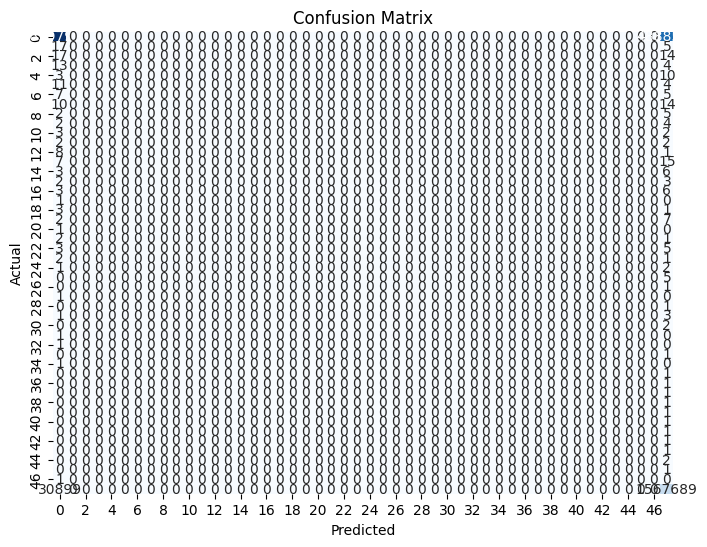

: 

In [ ]:
plot_confusion_matrix(family_confusion_matrix)

    c)Use skin pixel classification to detect the face in a portrait image (find a minimal square that
    frames the human face). Do not use an already implemented face detection function. 

In [ ]:
def detectSkinRGBspace(image):
    mask = (image[:, :, 2] > 95) & (image[:, :, 1] > 40) & (image[:, :, 0] > 20) & \
           ((np.max(image, axis=2) - np.min(image, axis=2)) > 15) & \
           (np.abs(image[:, :, 2] - image[:, :, 1]) > 15) & \
           (image[:, :, 2] > image[:, :, 1]) & (image[:, :, 2] > image[:, :, 0])
    return mask

def detectSkinHSVspace(image):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    mask = ((hsv[:, :, 0] <= 50) | (hsv[:, :, 0] >= 340)) & \
           (hsv[:, :, 1] >= 0.23 * 255) & (hsv[:, :, 2] >= 0.35 * 255)
    return mask

def detectSkinYCBRspace(image):
    ycbcr = cv.cvtColor(image, cv.COLOR_BGR2YCrCb)
    mask = (ycbcr[:, :, 0] > 80) & (85 < ycbcr[:, :, 1]) & (ycbcr[:, :, 1] < 135) & \
           (135 < ycbcr[:, :, 2]) & (ycbcr[:, :, 2] < 180)
    return mask

def process_images(folder_path):
    results = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            image = cv.imread(image_path)
            
            if image is not None:
                mask_rgb = detectSkinRGBspace(image)
                mask_hsv = detectSkinHSVspace(image)
                mask_ycbcr = detectSkinYCBRspace(image)

                detected_rgb = np.any(mask_rgb)
                detected_hsv = np.any(mask_hsv)
                detected_ycbcr = np.any(mask_ycbcr)
                
                results[filename] = {
                    'RGB': 'Detected' if detected_rgb else 'Not detected',
                    'HSV': 'Detected' if detected_hsv else 'Not detected',
                    'YCbCr': 'Detected' if detected_ycbcr else 'Not detected'
                }

    for img, res in results.items():
        print(f"Image: {img}")
        for space, status in res.items():
            print(f"  {space}: {status}")
        print()

process_images('Pratheepan_Dataset/FacePhoto')
